In [102]:
from gensim.models import Word2Vec
from w2v_random_forest import W2V_RandomForest
from w2v_kmeans import W2V_KMeans

from datetime import datetime
import re
import time
import numpy as np
import random
import argparse
import duckdb
import requests

from pathlib import Path

%matplotlib inline

In [103]:
db_string   = "/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/database/w2v_20240731_test.db"
output_dir  ='/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/logs/clustering/'

## UTILS

In [104]:
#
# W2V_PFAM_CLAN_MC1 has 15,481 entries
#
def execute_db_query():
    con = duckdb.connect(database=db_string)
    try:
        
        #results = con.execute("DESCRIBE W2V_PFAM_CLAN_MC1").fetchall()
        #results = con.execute("DESCRIBE W2V_CLAN_PFAM_COUNT").fetchall()
        #results = con.execute("SELECT DISTINCT CLAN_ID FROM W2V_PFAM_CLAN_MC1").fetchall()
        
        # really useful to find which clans have more than one pfam
        #results = con.execute("SELECT CLAN_ID, COUNT(*) AS item_count FROM W2V_PFAM_CLAN_MC1 GROUP BY CLAN_ID ORDER BY item_count DESC").fetchall()
        
        #results = con.execute("SELECT COUNT(*) FROM W2V_CLAN_PFAM_COUNT").fetchall()     
        #results = con.execute("SELECT COUNT(*) FROM W2V_PFAM_CLAN_MC1").fetchall()
        #results = con.execute("SELECT COUNT(*) FROM W2V_PFAM_CLAN_MC1 WHERE CLAN_ID='undef'").fetchall()
        result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
        
        #results = con.execute("SELECT CLAN_ID, COUNT(*) AS item_count FROM W2V_PFAM_CLAN_MC1 GROUP BY CLAN_ID").fetchall()

        for res in results:
            print(res)
    except Exception as e:
        print('Error executing query :', e)
        con.close()
        return
    con.close()
execute_db_query()

Error executing query : name 'pfam_id' is not defined


In [105]:
#
# W2V_PFAM_CLAN_MC1 has 15,481 entries
#
def get_clan_pfam_counts():
    con = duckdb.connect(database=db_string)
    try:

        # really useful to find which clans have more than one pfam
        results = con.execute("SELECT CLAN_ID, COUNT(*) AS item_count FROM W2V_PFAM_CLAN_MC1 GROUP BY CLAN_ID ORDER BY item_count DESC").fetchall()

        for res in results:
            print(res)
    except Exception as e:
        print('Error executing query :', e)
        con.close()
        return
    con.close()
    
get_clan_pfam_counts()

('undef', 7966)
('CL0123', 361)
('CL0020', 337)
('CL0159', 292)
('CL0063', 226)
('CL0023', 216)
('CL0036', 174)
('CL0186', 138)
('CL0010', 118)
('CL0021', 115)
('CL0236', 95)
('CL0167', 90)
('CL0266', 88)
('CL0105', 80)
('CL0193', 80)
('CL0072', 78)
('CL0219', 75)
('CL0028', 73)
('CL0202', 73)
('CL0029', 71)
('CL0126', 63)
('CL0229', 62)
('CL0125', 61)
('CL0172', 60)
('CL0361', 58)
('CL0192', 52)
('CL0004', 51)
('CL0110', 49)
('CL0113', 49)
('CL0051', 46)
('CL0059', 43)
('CL0220', 42)
('CL0257', 38)
('CL0369', 38)
('CL0268', 36)
('CL0221', 36)
('CL0016', 36)
('CL0083', 35)
('CL0260', 34)
('CL0108', 33)
('CL0103', 33)
('CL0057', 33)
('CL0671', 32)
('CL0116', 32)
('CL0039', 30)
('CL0179', 29)
('CL0214', 29)
('CL0055', 29)
('CL0053', 29)
('CL0015', 28)
('CL0174', 28)
('CL0287', 27)
('CL0198', 26)
('CL0032', 26)
('CL0001', 26)
('CL0280', 25)
('CL0165', 25)
('CL0177', 24)
('CL0209', 24)
('CL0137', 22)
('CL0431', 22)
('CL0263', 21)
('CL0048', 21)
('CL0037', 21)
('CL0182', 21)
('CL0344', 21)


#### Interpro clans

In [106]:
#
# Query interpro for clan id associated with a pfam id. returns 'undef' if there is no match
#
def get_interpro_clan(pfam_id):
    # Example URL
    url = "https://www.ebi.ac.uk/interpro/api/entry/pfam/"+pfam_id+"/"  # Replace with the actual URL

    response = requests.get(url)
    if response.status_code == 200:
        content = response.text

        # Search for the token in the content
        # set_info":{"accession":"CL0192","name":"GPCR_A"}
        #token_match = re.search("set_info\":\{\"(acc.*)on\"", content)
        token_match = re.search("set_info\":\{\"acc.*(CL[0-9]+)\"", content)

        if token_match:
            token = token_match.group(1)  # Extract the token
            #print(f"{pfam_id}:{token}:")
            return token
        else:
            return 'undef'
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return 'error'

# these never return any value
error_items =['PF21611', 'PF13722', 'PF06631', 'PF21723', 'PF08333', 'PF11665', 'PF17539', 'PF11404', 'PF20928', 'PF20761', 'PF04649']
for pfam in error_items:
    print(get_interpro_clan(pfam))

<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_17021/4124576725.py:15: SyntaxWarning: invalid escape sequence '\{'
  token_match = re.search("set_info\":\{\"acc.*(CL[0-9]+)\"", content)


Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error
Failed to retrieve data. Status code: 410
error


In [107]:
# use to import dat file of clans into a table

#
# one off method to clean up a list of clans - seems to be some issue with import
#
def clean_dat():
    dat_file = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/clans/rand_rep_clans.dat"
    clean_dat_file = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/clans/rand_rep_clans_clean.dat"
    
    of = open(clean_dat_file, "w")
    
    with open(dat_file, 'r') as file:
        for j, line in enumerate(file):
            #print(line.strip())  # Strip removes any extra newline characters
            tokens = line.split("|")
            for i, token in enumerate(tokens):
                if i>0:
                    of.write('|')
                word = token.strip().strip('"')
                #word = word.rstrip()
                #word = word.lstrip()
                if(word == "_with"):
                    word = "undef"
                if(word == "undef_err"):
                    word = "undef"
                #print(f"{j}:{i}:{word}:")
                of.write(word)
            of.write('\n')
    of.close()
    return(clean_dat_file)


#
# check how duckdb would interpret a dat file
#
def sniff_tables():
    clean_dat_file = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/clans/rand_rep_clans_clean.dat"
    con = duckdb.connect(database=db_string) 
    results = con.execute(f"SELECT Prompt FROM sniff_csv('{clean_dat_file}', delim='|')").fetchall()
    for res in results:
        print(res)


#
# creates and loads clan data into a table
#
def create_clan_table():
    con = duckdb.connect(database=db_string)
    try:          
        con.execute("CREATE TABLE W2V_RAND_REP_CLAN AS SELECT * FROM read_csv('/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/clans/rand_rep_clans_clean.dat', delim='|', header='false', columns={'pfam_id' :'VARCHAR', 'clan_id': 'VARCHAR'})")
        #print('table created')
        #con.execute("CREATE INDEX PF_CL_MC1_IDX ON W2V_PFAM_CLAN_MC1(PFAM_ID)")
        #print('idx created')
        count = con.execute("SELECT COUNT(*) FROM W2V_RAND_REP_CLAN").fetchall()
        print(f"count items : {count}")
    except Exception as e:
        print('Error', e)
        con.close()
        return
    con.close()

#clean_dat()
#sniff_tables()
create_clan_table()

Error Catalog Error: Table with name "W2V_RAND_REP_CLAN" already exists!


In [108]:
def find_files(directory, extn):
    files_info = []
    # Traverse the directory recursively
    for file_path in Path(directory).rglob(f"*{extn}"):
        if file_path.is_file():  # Check if it's a file
            filename = file_path.stem  # Get the filename without extension
            file_extension = file_path.suffix  # Get the file extension
            files_info.append((str(file_path), filename, file_extension))
    return files_info

### Check model type

In [ ]:
model_dir       = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/models/0920_g50/cbow/"

def find_model_type(model_name, model_path):
    try:
        model = Word2Vec.load(model_path)
        print(f"{model_name} \t: {model.sg}")
    except Exception as e:
        print(f"Error loading {model_name}. {e}")
    

model_files     = find_files(model_dir, 'model')
for model_file in model_files:
    model_path  = model_file[0]
    model_name  = model_file[1]
    model_path  = model_dir+model_name+'.model'
    #print(model_path)
    find_model_type(model_name, model_path)
    

### PCA Graphs

#### PCA 1, 2

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

def graph_2d_pca_color(X_full, categories, title):
    comic_font  = {'fontname':'Comic Sans MS'}
    helv_font   = {'fontname':'Helvetica'}
    
    categores_np        = np.array(categories)
    unique_categories   = np.unique(categores_np)
    
    # reduce X into 2 dimensions
    pca = PCA(n_components=2)
    X   = pca.fit_transform(X_full)

    # Define a colormap that can handle the variable number of categories
    cmap = plt.get_cmap('tab20', len(unique_categories))

    # Plotting
    plt.figure(figsize=(8, 6))

    # Scatter plot where the color depends on the category
    for i, category in enumerate(unique_categories):

        # get indices for current category    
        indices = np.where(categores_np == category)
        X_cat = X[indices]
        
        # Plot points with a color corresponding to the category
        plt.scatter(X_cat[:, 0], X_cat[:, 1], label=f'clan {category}', color=cmap(i), s=10)
        
    # Add title and labels
    plt.xlabel("W2V Vocab Embedding - Principal Component 1")
    plt.ylabel("W2V Vocab Embedding - Principal Component 2")
    plt.title(title, **helv_font)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right')

    # Show the plot
    plt.tight_layout()
    plt.show()

#### PCA 3

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def graph_3d_pca_colour(X_full, categories, title, draw_legend):
    comic_font  = {'fontname':'Comic Sans MS'}
    helv_font   = {'fontname':'Helvetica'}
    
    categories_np       = np.array(categories)
    unique_categories   = np.unique(categories_np)
    
    print(f"Plotting {X_full.shape[0]} from {len(unique_categories)} categories")

    # Apply PCA to reduce the dimensionality to 3D
    pca = PCA(n_components=3)
    X   = pca.fit_transform(X_full)

    # Create a 3D scatter plot and a colour map - one per category
    fig     = plt.figure(figsize=(8, 6))
    ax      = fig.add_subplot(111, projection='3d')
    cmap    = plt.cm.get_cmap('tab20', len(unique_categories))
    
    # set various colours of the graph
    fig.patch.set_facecolor('white')    # Overall figure background - incl labels
    ax.set_facecolor('white')           # Plot background
    
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True

    # Set the color you want for the plot area (inside the axes)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # light gray
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # light gray
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # light gray
    
    # grid colour
    ax.xaxis._axinfo['grid'].update(color='lightgrey')
    ax.yaxis._axinfo['grid'].update(color='lightgrey')
    ax.zaxis._axinfo['grid'].update(color='lightgrey')
    
    # Plot each point in the corresponding color based on its category
    for i, category in enumerate(unique_categories):
        # get indices for current category    
        indices = np.where(categories_np == category)
        X_cat   = X[indices]
        
        # include and/or remove labels
        if(draw_legend):
            ax.scatter(X_cat[:, 0], X_cat[:, 1], X_cat[:, 2], label=f'Clan {category}', color=cmap(i), s=10)
        else:
            ax.scatter(X_cat[:, 0], X_cat[:, 1], X_cat[:, 2], color=cmap(i), s=10)

    # Add labels and title
    ax.set_xlabel('W2V Vocab - PC 1')
    ax.set_ylabel('W2V Vocab - PC 2')
    ax.set_zlabel('W2V Vocab - PC 3')
    ax.set_title(title)

    # Show legend and plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()

#graph_3d_pca_colour()

### KMeans Cluster - Matrix Heatmap

<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_17021/1591132193.py:16: SyntaxWarning: invalid escape sequence '\.'
  k_percent_s    = re.search("jaccard_([0-9\.]*)", score_name)


Loading matrix 0910_g1_w2v_20240910_skip_mc8_w44_v100_g1_mcs100_kmeans_jaccard_0.5
 50.0


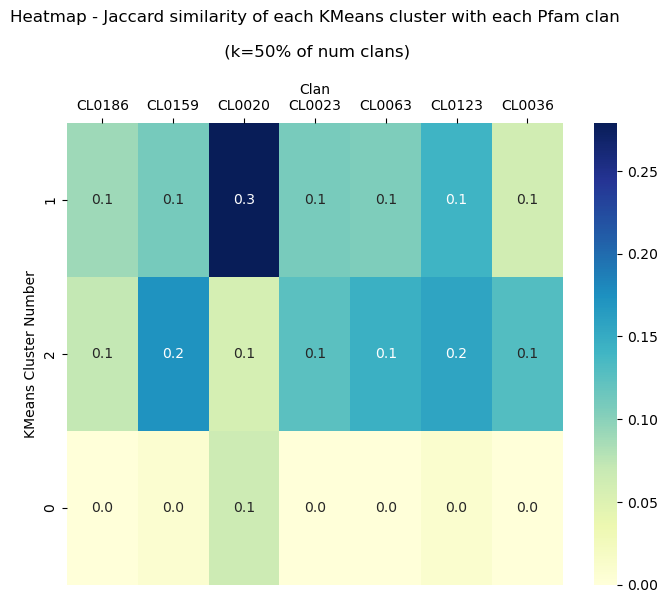

Loading matrix 0910_g1_w2v_20240910_skip_mc8_w44_v100_g1_mcs100_kmeans_jaccard_0.75
 75.0


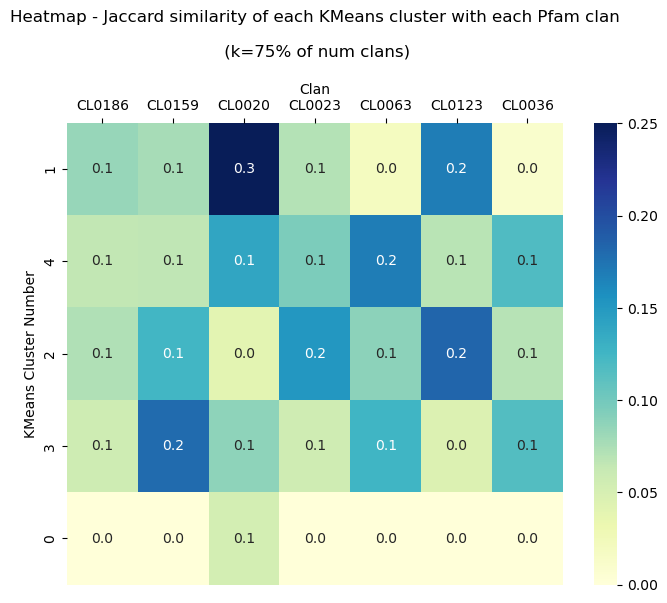

Loading matrix 0910_g1_w2v_20240910_skip_mc8_w44_v100_g1_mcs100_kmeans_jaccard_1.0
 100.0


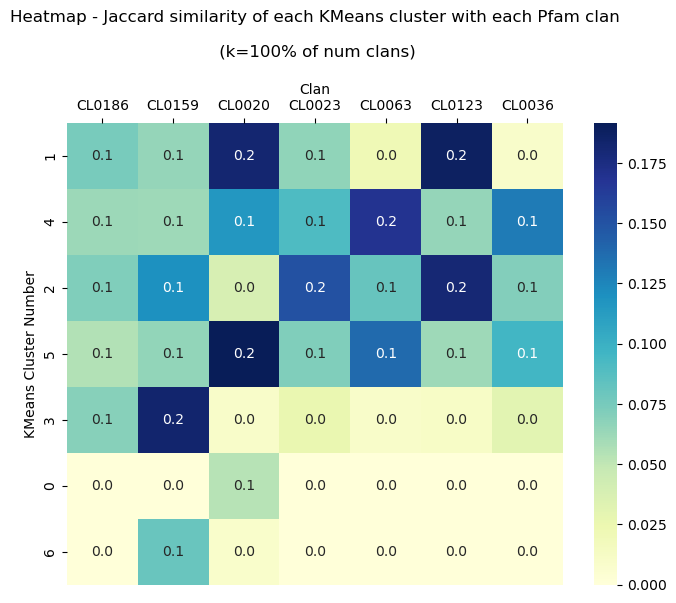

Loading matrix 0910_g1_w2v_20240910_skip_mc8_w44_v100_g1_mcs100_kmeans_jaccard_0.25
 25.0


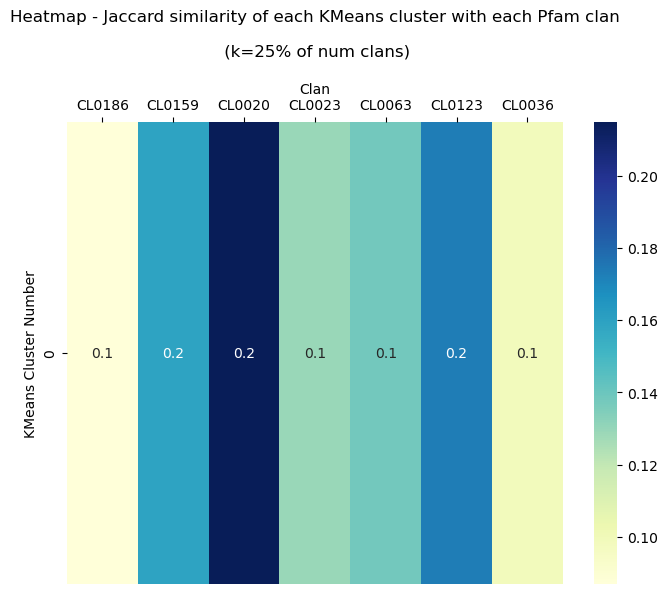

In [118]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    

# use w2v_run_clusterin.py to save jaccard similarity matrices to a folder and sepcify that folder here
score_dir='/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/clusters/sim_matrices/'

matrix_files     = find_files(score_dir, 'npy')
for matrix_file_info in matrix_files:
    
    score_file = matrix_file_info[0]
    score_name = matrix_file_info[1]
    
    print(f"Loading matrix {score_name}")
    k_percent_s    = re.search("jaccard_([0-9\.]*)", score_name)
    k_percent = float(k_percent_s.group(1)) * 100
    
    print(f" {k_percent}")
    
    # matrices have been saved within wv2_run_clustering
    npy_f           = open(score_file, 'rb')
    score_matrix    = np.load(npy_f) #loads second matrix
    k_keys          = np.load(npy_f) #loads second matrix
    clan_keys       = np.load(npy_f) #loads second matrix

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(score_matrix, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=clan_keys, yticklabels=k_keys)

    # Add labels and title
    plt.xlabel('Clan')
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    plt.ylabel('KMeans Cluster Number')
    plt.title(f"Heatmap - Jaccard similarity of each KMeans cluster with each Pfam clan\n\n (k={int(k_percent)}% of num clans)\n")
    plt.show()




### PFAM Vocab utils

In [111]:
#
# extracts the words used in a word2vec model by wuerying the model itself
# returns a list of words with any whitespace remoived as well as count of the umber of items
#       
def get_pfam_vocab(model_path, exclude_gaps=False):
    model = Word2Vec.load(model_path)
    
    vocab         = model.wv.key_to_index
    pfam_vocab    = []
    for i, word in enumerate(vocab):
        if ( exclude_gaps and (word == 'GAP' or word == 'START_GAP' or word == 'STOP_GAP' or word == 'DISORDER')):
            #print('ignoring', word)
            continue
        else:
            word = word.lstrip()
            word = word.rstrip()
            pfam_vocab.append(word)
    return pfam_vocab, len(pfam_vocab)


#
# Retrieves the pfams for a model as long as they belong to a clan
#
def get_pfam_vocab_clan_only(model_path):
    model = Word2Vec.load(model_path)    
    pfam_w_clan_ids  = []
    
    full_vocab, num_items = get_pfam_vocab(model_path)
    con = duckdb.connect(database=db_string)
    
    for pfam_id in full_vocab:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()

            if(result != []):
                #print(result)
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    #print(f" ----------------- adding {clan_result} for {pfam_result}")
                    pfam_w_clan_ids.append(pfam_result)
                #else:
                #    print(f"ignoring {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    con.close()
    
    return pfam_w_clan_ids

### Vectors for model

In [13]:
'''

# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words
# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can
# accurately predict the labels of a test set
#
def get_model_vectors_clan_only(model_path, min_count, vector_size):
    
    model = Word2Vec.load(model_path)
    # I just happen to know that we will end up with 6,133 words, each with a vector of 25 dimensions
    
    if(min_count == 'mc1'):
        num_rows = 7508
    elif(min_count == 'mc3'):
        num_rows = 6745
    elif(min_count == 'mc5'):
        num_rows = 6419
    elif(min_count == 'mc8'):
        num_rows = 6133
    
    # create matrices and arrays for data
    X           = np.empty((num_rows, vector_size))
    X_pfam_ids  = []
    Y           = []
    
    #print(f"Created matrix X {X.shape}")
    
    full_vocab, num_items = get_pfam_vocab(model_path)
    con = duckdb.connect(database=db_string)
    count = 0
    for pfam_id in full_vocab:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
            
            #if(result == []):
            #    print(f"No results for {pfam_id}")
            if(result != []):
                #print(result)
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    #print(f" ----------------- adding {clan_result} for {pfam_result}")
                    X_pfam_ids.append(pfam_result)
                    Y.append(clan_result)
                    X[count,:] = model.wv[pfam_result]
                    count +=1
                #else:
                #    print(f"ignoring {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    #print(f"model with mc {min_count} has {count} pfam-clan pairs.")
    con.close()
    
    return X, Y, X_pfam_ids
    '''

'\n\n# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words\n# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can\n# accurately predict the labels of a test set\n#\ndef get_model_vectors_clan_only(model_path, min_count, vector_size):\n    \n    model = Word2Vec.load(model_path)\n    # I just happen to know that we will end up with 6,133 words, each with a vector of 25 dimensions\n    \n    if(min_count == \'mc1\'):\n        num_rows = 7508\n    elif(min_count == \'mc3\'):\n        num_rows = 6745\n    elif(min_count == \'mc5\'):\n        num_rows = 6419\n    elif(min_count == \'mc8\'):\n        num_rows = 6133\n    \n    # create matrices and arrays for data\n    X           = np.empty((num_rows, vector_size))\n    X_pfam_ids  = []\n    Y           = []\n    \n    #print(f"Created matrix X {X.shape}")\n    \n    full_vocab, num_items = get_pfam_vocab(model_path)\n    co

In [112]:
#
# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words
# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can
# accurately predict the labels of a test set
#
def get_clustering_inputs(model_path, pfams_ids, vector_dims):
    
    model = Word2Vec.load(model_path)
    
    N = len(pfams_ids)
    D = vector_dims

    # create matrices and arrays for data
    X = np.empty((N, D))
    Y = []
    
    con     = duckdb.connect(database=db_string)
    count   = 0
    for pfam_id in pfams_ids:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID ='{pfam_id}'").fetchall()
            
            if(result == []):
                raise Exception(f"No results for {pfam_id}")

            if(result != []):
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    Y.append(clan_result)
                    X[count,:] = model.wv[pfam_result]
                    count +=1
                else:
                    print(f"ignoring {clan_result} for {pfam_result}")
                    raise Exception(f"Clan {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    con.close()
    
    return X, Y

In [113]:
#
# gets the count of pfams in a clan
#
def get_clan_count(clan_id):
    con = duckdb.connect(database=db_string)
    try:          
        result = con.execute(f"SELECT COUNT FROM W2V_CLAN_PFAM_COUNT WHERE CLAN_ID ='{clan_id}'").fetchall()
        con.close()
        if result is None or result == []:
            return 0
        else:
            return result[0][0]
            
    except Exception as e:
        print('get_clan_count - error', e)
        con.close()
        return
    con.close()


#### Get pfams for a model as long as the clans they are in have >1 pfam

In [114]:
#
# For a model, this method gets all the pfam words in the model and then finds the clan id in the database
# if the pfam entry is not in the database, it will return only pfams that are in clans that have more
# than min_clan_size entries
#
def get_pfam_clans_for_model(model_name, model_path, min_clan_size):
    #print(f"get_pfam_clans_for_model() {model_name}, {model_path}")
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    
    # call to various tility methods - get vocab that includes pfam ids only
    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    #print(f"{min_count}: Found {vocab_count}, pfam words in {model_name}. items[0-10] {vocab[0:10]}")
    
    # see if there is an entry
    con = duckdb.connect(database=db_string)
    
    filtered_clans  = []
    filtered_pfams  = []
    clan_dict       = {}
    filtered_clan_dict = {}
    
    # loop through each pfam, find its clan and build up a dictinary of clans > pfam_ids
    for pfam_id in vocab:
        try:          
            results = con.execute(f"SELECT CLAN_ID FROM W2V_PFAM_CLAN_MC1 WHERE PFAM_ID='{pfam_id}'").fetchall()
            
            # if no result, get from interpro
            if(results is None or results ==[]):
                clan_id = get_interpro_clan(pfam_id)
                print(f"----------> No local clan entry for {pfam_id}, queried interpro w/ result:{pfam_id}:{clan_id}")
                #con.execute(f"INSERT INTO W2V_PFAM_CLAN (PFAM_ID, CLAN_ID) VALUES ('{pfam_id}', '{clan_id}')")
            else:
                clan_id = results[0][0]
                if (clan_id != 'undef'):
                    #add clan id to dictionary
                    if clan_id in clan_dict:
                        clan_dict[clan_id].append(pfam_id)  # Append to the list if the key exists
                    else:
                        clan_dict[clan_id] = [pfam_id]
        except Exception as e:
            print('get_pfam_clans_for_model() error', e, results)
            con.close()
            return
    con.close()
    
    # get dictionary with only clans with more than one pfam
    filtered_clan_dict = {key:value for key, value in clan_dict.items() if len(value) >= min_clan_size}
    filtered_clans = list(filtered_clan_dict.keys())
    filtered_pfams = list(set([item for sublist in filtered_clan_dict.values() for item in sublist]))
    
    return filtered_pfams, filtered_clans, filtered_clan_dict


## RUN ME

w2v_20240910_skip_mc8_w44_v100_g1
Assessing model: w2v_20240910_skip_mc8_w44_v100_g1 type: skip mc: 8 ws: 44 vs: 100 : w/ vocab size: 12197
model w2v_20240910_skip_mc8_w44_v100_g1 8 vs:100 full vocab size : 12197 12197 | X: (6057, 100) | Y : 6057 | clans : 575
Plotting 6057 from 575 categories


/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_17021/2535935623.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap    = plt.cm.get_cmap('tab20', len(unique_categories))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


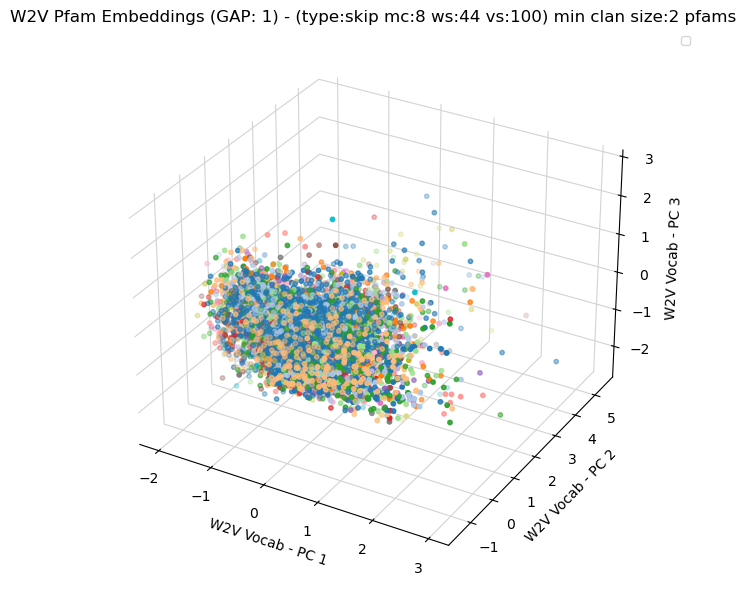

w2v_20240910_skip_mc8_w44_v25_g1
Assessing model: w2v_20240910_skip_mc8_w44_v25_g1 type: skip mc: 8 ws: 44 vs: 25 : w/ vocab size: 12197
model w2v_20240910_skip_mc8_w44_v25_g1 8 vs:25 full vocab size : 12197 12197 | X: (6057, 25) | Y : 6057 | clans : 575
Plotting 6057 from 575 categories


/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_17021/2535935623.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap    = plt.cm.get_cmap('tab20', len(unique_categories))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


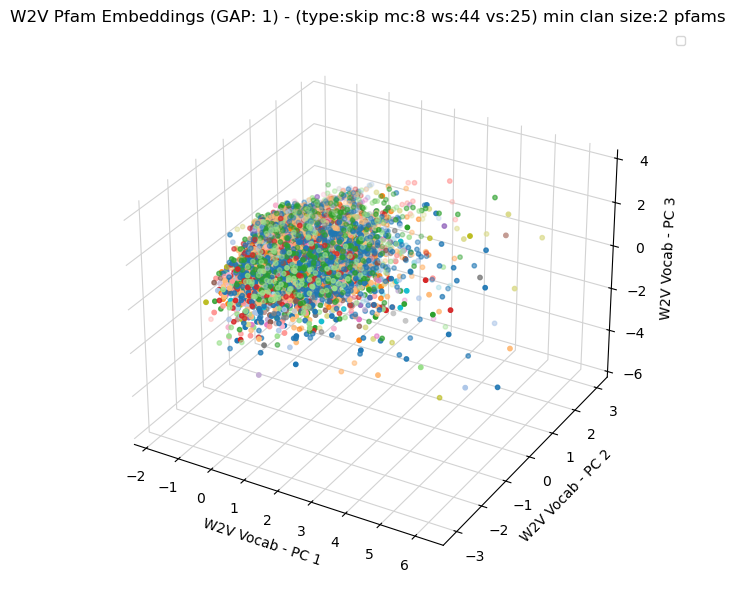

In [117]:
'''
('undef', 7966) ('CL0123', 361) ('CL0020', 337)
('CL0159', 292) ('CL0063', 226) ('CL0023', 216)

('CL0036', 174) ('CL0186', 138) ('CL0010', 118)
('CL0021', 115) ('CL0236', 95) ('CL0167', 90)
'''

# ------------------ config

min_cs         = 2
model_dir      = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/models/0910_g1/graph/"
#model_dir     = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/models/0920_g50/graph/"
#model_dir     = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/data/models/0922_g100/graph/"

draw_legend = False

# ------------------ run

# find files
model_files     = find_files(model_dir, 'model')
for model_file in model_files:
    model_path  = model_file[0]
    model_name  = model_file[1]
    
    print(model_name)

    # get info from filename for logging purposes
    type_s      = re.search("_([a-zA-Z0-9]+)_mc", model_name)
    type        = type_s.group(1)
    gap_s       = re.search("_g([0-9]+)", model_name)
    gap_size    = gap_s.group(1)
    vector_s    = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)
    min_count_s = re.search("mc([0-9]+)_", model_name)
    min_count   = min_count_s.group(1)
    vector_s    = re.search("_v([0-9]+)", model_name)
    vector_size = vector_s.group(1)
    window_s    = re.search("_w([0-9]+)_", model_name)
    window_size = window_s.group(1)
    
    
    # get vocab for model
    full_vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    
    print(f"Assessing model: {model_name} type: {type} mc: {min_count} ws: {window_size} vs: {vector_size} : w/ vocab size: {vocab_count}")
    filtered_pfams, filtered_clans, filtered_clan_dict = get_pfam_clans_for_model(model_name, model_path, min_cs)
    
    X, Y = get_clustering_inputs(model_path, filtered_pfams, int(vector_size))
    
    print(f"model {model_name} {min_count} vs:{vector_size} full vocab size : {vocab_count} {len(full_vocab)} | X: {X.shape} | Y : {len(Y)} | clans : {len(filtered_clans)}")
    
    title = 'W2V Pfam Embeddings (GAP: ' + gap_size+ ') - (type:' + type + ' mc:' + str(min_count) +' ws:' + str(window_size) +' vs:' + str(vector_size) + ') min clan size:'+ str(min_cs)+' pfams'

    # Perform PCA and plot results - color coded per clan
    #graph_2d_pca_color(X, Y, title)
    graph_3d_pca_colour(X, Y, title, False)


#### Example clustering drawings

/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_52923/2184914737.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(group_sizes) + 10)  # Tab20 colormap


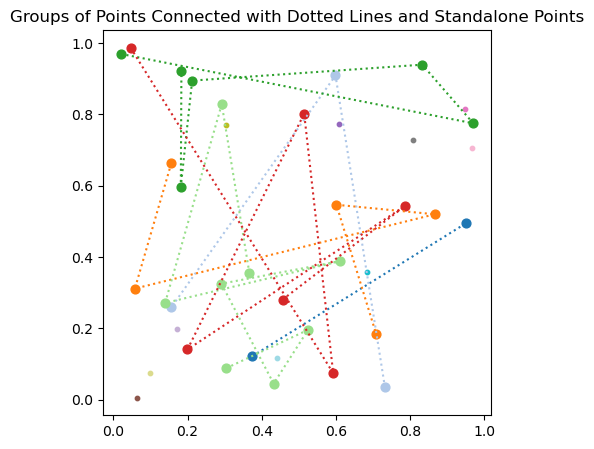

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Generate random positions for the points
np.random.seed(42)  # for reproducibility
x = np.random.rand(40)
y = np.random.rand(40)

# Group configuration
group_sizes = [2, 3, 5, 6, 8, 6]  # Group sizes that sum to 30 points
group_start = 0
colormap = cm.get_cmap('tab20', len(group_sizes) + 10)  # Tab20 colormap

# Create plot
plt.figure(figsize=(5, 5))

# Plot the groups and connect them with dotted lines
for i, group_size in enumerate(group_sizes):
    group_x = x[group_start:group_start + group_size]
    group_y = y[group_start:group_start + group_size]
    
    # Plot the points in the group with the same color
    plt.scatter(group_x, group_y, s=40, color=colormap(i))
    
    # Connect the points with dotted lines
    plt.plot(group_x, group_y, linestyle=':', color=colormap(i))
    
    group_start += group_size

# Plot the remaining 10 points with different colors
for i in range(30, 40):
    plt.scatter(x[i], y[i], s=10, color=colormap(len(group_sizes) + (i - 30)))

# Show plot (no legend)
plt.title('Groups of Points Connected with Dotted Lines and Standalone Points')
plt.show()



/var/folders/kp/bqnb4b7n4ng50xtbznpbx7xh0000gn/T/ipykernel_52923/739604062.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(group_sizes) + 10)  # Tab20 colormap


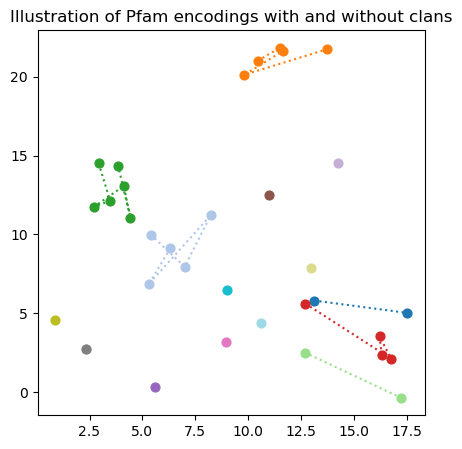

: 

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Generate random positions for the points
np.random.seed(42)  # for reproducibility

# Generate random points for the standalone points (wide spread)
x_standalone = np.random.rand(10) * 15  # Scaled up for wider spread
y_standalone = np.random.rand(10) * 15

# Group configuration: smaller spread for grouped points
group_sizes = [2, 5, 5, 6, 2, 4]  # Group sizes that sum to 30 points
group_start = 0
colormap = cm.get_cmap('tab20', len(group_sizes) + 10)  # Tab20 colormap

# Base locations for each group (to keep them clustered)
group_bases = np.random.rand(len(group_sizes), 2) * 25  # Central points for each group

# Create plot
plt.figure(figsize=(5, 5))

# Plot the groups and connect them with dotted lines
spread_factor = 5.0  # Adjust this factor to change the spread of points in each group

for i, group_size in enumerate(group_sizes):
    group_base_x, group_base_y = group_bases[i]
    
    # Generate points with larger offsets for more spread (adjust the spread_factor)
    group_x = group_base_x + (np.random.rand(group_size) - 0.5) * spread_factor
    group_y = group_base_y + (np.random.rand(group_size) - 0.5) * spread_factor
    
    # Plot the points in the group with the same color
    plt.scatter(group_x, group_y, s=40, color=colormap(i))
    
    # Connect the points with dotted lines
    plt.plot(group_x, group_y, linestyle=':', color=colormap(i))
    
# Plot the remaining 10 standalone points (with a wider spread and different colors)
for i in range(10):
    plt.scatter(x_standalone[i], y_standalone[i], s=40, color=colormap(len(group_sizes) + i))

# Show plot (no legend)
plt.title('Illustration of Pfam encodings with and without clans')
plt.show()


## Jaccard Similarity of clusters

In [ ]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union
 
set_a = {"Geeks", "for", "Geeks", "NLP", "DSc"}
set_b = {"Geek", "for", "Geeks", "DSc.", 'ML', "DSA"}
 
similarity = jaccard_similarity(set_a, set_b)
print("Jaccard Similarity:", similarity)

## General Corpus and Model Graphs

In [61]:
header_columns = ['rank', 'creation_time', 'model', 'type', 'mc', 'ws', 'vs', 'time']
model_creation_file = "/Users/patrick/dev/ucl/word2vec/comp_0158_msc_project/logs/model_creation/0910/0910_aws_cbow_creation_times.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(model_creation_file, sep=',', engine='python')
df.head()

## DEFINE MODELS & GET VOCAB VECTORS

### Graph the vectors in a model vocab

In [ ]:
#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
#model_names=['w2v_20240901_sg1_mc8_w8_v5', 'w2v_20240901_sg1_mc8_w8_v10', 'w2v_20240901_sg1_mc8_w8_v25', 'w2v_20240901_sg1_mc8_w8_v50', 'w2v_20240901_sg1_mc8_w8_v75', 'w2v_20240901_sg1_mc8_w8_v100']

#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']

model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']
model_names = ['w2v_20240908_sg1_mc1_w3_v500']

for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    # get vocab for model
    #vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Min Count 8 - Window Size 13

In [ ]:
model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
model_names=['w2v_20240901_sg1_mc8_w13_v5', 'w2v_20240901_sg1_mc8_w13_v10', 'w2v_20240901_sg1_mc8_w13_v25', 'w2v_20240901_sg1_mc8_w13_v50', 'w2v_20240901_sg1_mc8_w13_v75', 'w2v_20240901_sg1_mc8_w13_v100']


for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Min Count 8 - Window Size 44

In [ ]:
model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
model_names=['w2v_20240903_sg1_mc8_w44_v5', 'w2v_20240903_sg1_mc8_w44_v10', 'w2v_20240903_sg1_mc8_w44_v25', 'w2v_20240903_sg1_mc8_w44_v50', 'w2v_20240903_sg1_mc8_w44_v75', 'w2v_20240902_sg1_mc8_w44_v100']


for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Graph the models

In [ ]:
graph_2d(X, model_name)